# Term Project - NBA Player Projections

### Add your name(s) and EIDs below
- Student Name: Juan Chavarria
- Student UT EID: jac23763
- Partner Name: Leo Kern
- Partner UT EID: mlk2755

# Player Projections
For this project, we are attempting to use data from the careers of NBA players to predict various career statistics. The NBA and how it is played has changed all throughout its existance, so we will be limiting our scope to players who's rookie year was at least 1989. This year marked a change in the NBA draft. In years prior to 1989, there were multiple rounds, with over 150 players being selected throughout the draft. Starting in 1989, the NBA switched to two-round draft, where only about 60 players were selected.

In [1]:
# headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve
%matplotlib inline

In [2]:
# load dataset - draft positions, clean dataset to be just players drafted starting in 1989
url = 'https://drive.google.com/file/d/1dqWNP3S5gAMwK31446UilDzEmiMwb5sx/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
draft_data = pd.read_csv(url)
draft_data.set_index('player_name', inplace = True)
draft_data.rename_axis('Player', inplace = True)
draft_data.drop(draft_data[draft_data['season']<1989].index, inplace=True)

# only need round_number, round_pick, overall_pick
draft_data = draft_data[['round_number', 'round_pick', 'overall_pick']]
draft_data

,round_number,round_pick,overall_pick
Player,,,
Pervis Ellison,1,1,1
Danny Ferry,1,2,2
Sean Elliott,1,3,3
Glen Rice,1,4,4
J.R. Reid,1,5,5
...,...,...,...
Yannick Nzosa,2,24,54
Gui Santos,2,25,55
Luke Travers,2,26,56


In [3]:
# load dataset - player careers, clean dataset to be just players drafted starting in 1989
url = 'https://drive.google.com/file/d/1Zqli9nAik92gYldsUxIdxkZanssQkwAD/view?usp=sharin'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
player_data = pd.read_csv(url)
player_data.set_index('Player', inplace = True)
player_data.drop(player_data[player_data['From']<1989].index, inplace=True)

# do not need every column. Some are advanced stats, measurements, or unrelated to 1989 players
dropping = ['From', 'To', 'Pos', 'Ht', 'Height', 'Wt', 'eFG%',
            'WS', 'PER', 'AS MVP', 'All ABA', 'NBA 75 Team', 'ABA All-Time Team']
player_data.drop(dropping, axis = 1, inplace = True)
player_data

,Years,G,PTS,TRB,AST,FG%,FG3%,FT%,All Star,All NBA,...,AST Champ,Scoring Champ,Most Improved,Sixth Man,DPOY,ROY,CF MVP,Finals MVP,MVP,Championships
Player,,,,,,,,,,,,,,,,,,,,,
Alaa Abdelnaby,5,256,5.7,3.3,0.3,50.2,0.0,70.1,0,0,...,0,0,0,0,0,0,0,0,0,0
Mahmoud Abdul-Rauf,11,586,14.6,1.9,3.5,44.2,35.4,90.5,0,0,...,0,0,1,0,0,0,0,0,0,0
Tariq Abdul-Wahad,6,236,7.8,3.3,1.1,41.7,23.7,70.3,0,0,...,0,0,0,0,0,0,0,0,0,0
Shareef Abdur-Rahim,12,830,18.1,7.5,2.5,47.2,29.7,81.0,1,0,...,0,0,0,0,0,0,0,0,0,0
Álex Abrines,3,174,5.3,1.4,0.5,38.7,36.8,88.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Derrick Zimmerman,1,2,2.0,2.0,3.5,66.7,27.9,73.7,0,0,...,0,0,0,0,0,0,0,0,0,0
Stephen Zimmerman,1,19,1.2,1.8,0.2,32.3,14.2,60.0,0,0,...,0,0,0,0,0,0,0,0,0,0
Paul Zipser,2,98,4.7,2.6,0.8,37.1,33.5,76.9,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# adding draft data to player_data dataframe, drop players that are not in both
df = player_data.join(draft_data)
df.dropna(inplace = True)
df

,Years,G,PTS,TRB,AST,FG%,FG3%,FT%,All Star,All NBA,...,Sixth Man,DPOY,ROY,CF MVP,Finals MVP,MVP,Championships,round_number,round_pick,overall_pick
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Bramlett,1,8,1.0,2.8,0.0,19.0,14.2,62.5,0,0,...,0,0,0,0,0,0,0,2.0,10.0,39.0
A.J. English,2,151,9.9,2.1,2.1,43.5,13.8,77.8,0,0,...,0,0,0,0,0,0,0,2.0,10.0,37.0
A.J. Guyton,3,80,5.5,1.0,1.8,37.7,37.8,82.2,0,0,...,0,0,0,0,0,0,0,2.0,3.0,32.0
Aaron Brooks,11,645,9.7,1.7,3.0,41.3,37.0,83.7,0,0,...,0,0,0,0,0,0,0,1.0,26.0,26.0
Aaron Gordon,8,528,13.0,6.3,2.5,46.0,32.3,70.2,0,0,...,0,0,0,0,0,0,0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhaire Smith,2,13,3.7,1.2,0.9,37.8,31.6,66.7,0,0,...,0,0,0,0,0,0,0,1.0,16.0,16.0
Zhou Qi,2,19,1.3,1.2,0.1,21.2,10.5,66.7,0,0,...,0,0,0,0,0,0,0,2.0,13.0,43.0
Ziaire Williams,1,62,8.1,2.1,1.0,45.0,31.4,78.2,0,0,...,0,0,0,0,0,0,0,1.0,10.0,10.0



# Part 1: Data Analysis

How complete is our data? We can only use this data to predict NBA players if our data is an accurate representation of all NBA players. While there many different data columns from the player_data csv file, we will only look at three statistics: career averages in points, rebounds, and assists. 

C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\2125014518.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['label'] = l


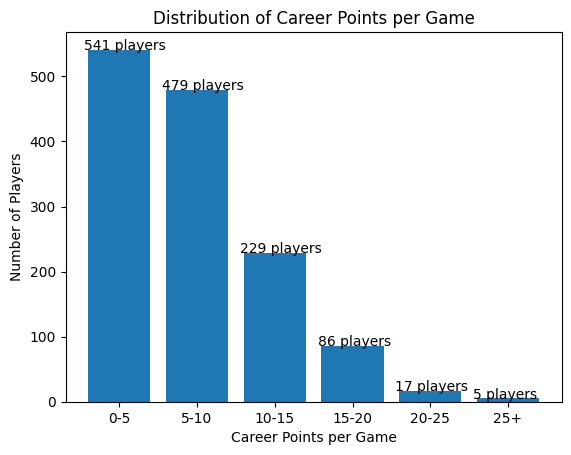

In [5]:
# Distribution of career points per game
points = df[['PTS']]
l = []
label_key = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']

# labeing points per game for every player in dataset
for index, row in points.iterrows():
    p = row['PTS']
    if p < 5:
        l.append(0)
    elif p < 10:
        l.append(1)
    elif p < 15:
        l.append(2)
    elif p < 20:
        l.append(3)
    elif p < 25:
        l.append(4)
    else:
        l.append(5)
l = np.array(l)
points['label'] = l

# grouping by values
bar = points.groupby(['label']).size()

# plotting
plt.bar(label_key, bar.values)
plt.title('Distribution of Career Points per Game')
plt.ylabel('Number of Players')
plt.xlabel('Career Points per Game')

for i in range(6):
    string = str(bar.values[i])
    string += ' players'
    plt.text((bar.index.values[i]-0.45), bar.values[i], string) #adding bar labels

plt.show()

C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\1948866640.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebounds['label'] = l


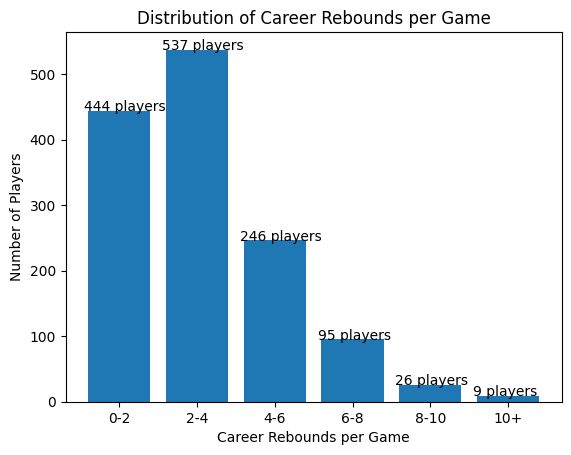

In [6]:
# Distribution of career rebounds per game
rebounds = df[['TRB']]
l = []
label_key = ['0-2', '2-4', '4-6', '6-8', '8-10', '10+']

# labeing points per game for every player in dataset
for index, row in rebounds.iterrows():
    r = row['TRB']
    if r < 2:
        l.append(0)
    elif r < 4:
        l.append(1)
    elif r < 6:
        l.append(2)
    elif r < 8:
        l.append(3)
    elif r < 10:
        l.append(4)
    else:
        l.append(5)
l = np.array(l)
rebounds['label'] = l

# grouping by values
bar = rebounds.groupby(['label']).size()

# plotting
plt.bar(label_key, bar.values)
plt.title('Distribution of Career Rebounds per Game')
plt.ylabel('Number of Players')
plt.xlabel('Career Rebounds per Game')

for i in range(6):
    string = str(bar.values[i])
    string += ' players'
    plt.text((bar.index.values[i]-0.45), bar.values[i], string) #adding bar labels

plt.show()

C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\2805926066.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assists['label'] = l


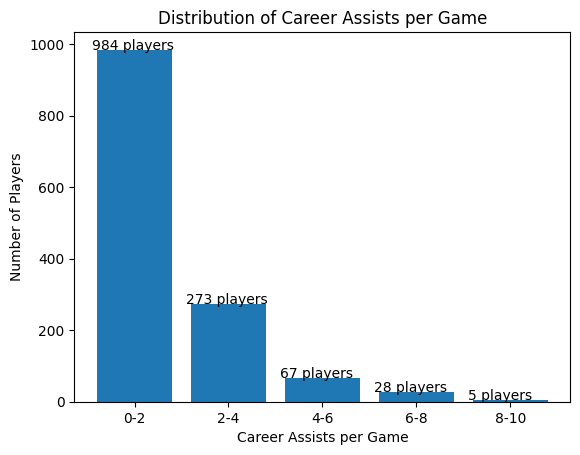

In [7]:
# Distribution of career assists per game
assists = df[['AST']]
l = []
label_key = ['0-2', '2-4', '4-6', '6-8', '8-10']

# labeing points per game for every player in dataset
for index, row in assists.iterrows():
    a = row['AST']
    if a < 2:
        l.append(0)
    elif a < 4:
        l.append(1)
    elif a < 6:
        l.append(2)
    elif a < 8:
        l.append(3)
    elif a < 10:
        l.append(4)
    else:
        l.append(5)
l = np.array(l)
assists['label'] = l

# grouping by values
bar = assists.groupby(['label']).size()

# plotting
plt.bar(label_key, bar.values)
plt.title('Distribution of Career Assists per Game')
plt.ylabel('Number of Players')
plt.xlabel('Career Assists per Game')

for i in range(5):
    string = str(bar.values[i])
    string += ' players'
    plt.text((bar.index.values[i]-0.45), bar.values[i], string) #adding bar labels
    
plt.show()

Based on the three graphs above, we can conclude that our data is complete. It covers the expected range of career points, rebounds, and assists of NBA players. 

Most of our players have very low career point averages, which is expected. Not every player who makes the NBA will score at a high volume. NBA players, on average, have a short career, so they do not have the time to develop into a real scorer. Additonally, not every player will get significant playing time, let alone start, where most of a team's points come from. This means that even if a player does not have a short career, they still might not have opportunity to score during games. 

Like career points, the career assist average shows that most players fall into the category with the least amount of assists. For reasons similar to why players do not always score, NBA players will not always have assists.

Career rebounds shows a slightly different distribution, as most of our players fall into the 2nd least category, rather than the lowest category. This also makes sense, because all players have a relatively equal opportunity to rebound a missed shot. Additionally, there are plenty of chances each game to secure a rebound, whereas a player will not have the same opportunity to score or assist each game. 


# Part 2: Data Predictions

Now that our data can be used for different estimations, we create various models and evaluate their performances. 


### Question 1: Projections Based on Draft Position

Using the overall draft position of players, can career stats be (loosely) estimated? There are many stories of players drafted late in the draft, or even players who go completely undrafted, who find success in the NBA. Therefore, we suspect that there will be a weak correlation between draft position and career stats. Here, we will only evaluate career averages in points, rebounds, and assists, as well as looking at the sum of these three statistics. 

The regression coefficient is 0.28288943234138975



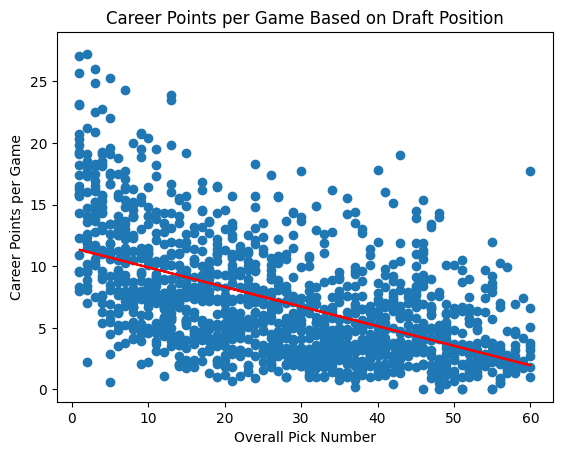

In [8]:
# part 1: career points per game
draft_position = df[['overall_pick']].values.reshape(-1,1).astype(int)
ppg = df[['PTS']].values.reshape(-1,1).astype(float)
X_train, X_test, y_train, y_test = train_test_split(draft_position, ppg, test_size=0.2, random_state = 123)

# create model and fit to data
model = LinearRegression()
model.fit(draft_position, ppg)
coeff = model.score(draft_position, ppg)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
y_pred = X_test * slope + intercept
y_pred = y_pred.round(decimals = 1)

# regression coefficient
print('The regression coefficient is', coeff)
print()

# plotting
plt.scatter(draft_position, ppg)
plt.plot(draft_position, (draft_position * slope + intercept), 'r')
plt.title('Career Points per Game Based on Draft Position')
plt.xlabel('Overall Pick Number')
plt.ylabel('Career Points per Game')
plt.ylim([-1,29])
plt.show()

The regression coefficient is 0.2130640222155027



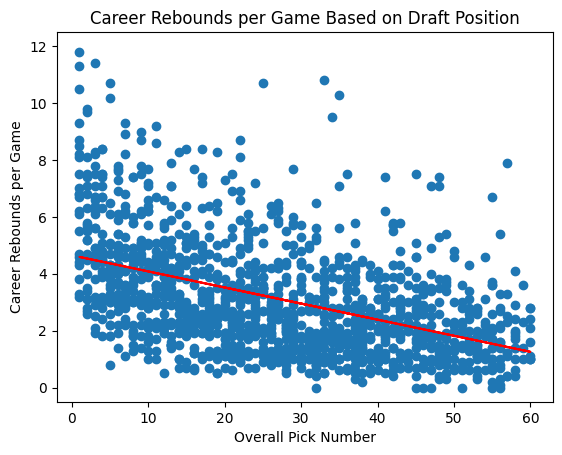

In [9]:
# part 2: career rebounds per game
draft_position = df[['overall_pick']].values.reshape(-1,1).astype(int)
rb = df[['TRB']].values.reshape(-1,1).astype(float)
X_train, X_test, y_train, y_test = train_test_split(draft_position, rb, test_size=0.2, random_state = 123)

# create model and fit to data
model = LinearRegression()
model.fit(draft_position, rb)
coeff = model.score(draft_position, rb)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
y_pred = X_test * slope + intercept
y_pred = y_pred.round(decimals = 1)

# regression coefficient
print('The regression coefficient is', coeff)
print()

# plotting
plt.scatter(draft_position, rb)
plt.plot(draft_position, (draft_position * slope + intercept), 'r')
plt.title('Career Rebounds per Game Based on Draft Position')
plt.xlabel('Overall Pick Number')
plt.ylabel('Career Rebounds per Game')
plt.ylim([-0.5,12.5])
plt.show()

The regression coefficient is 0.12982430072111673



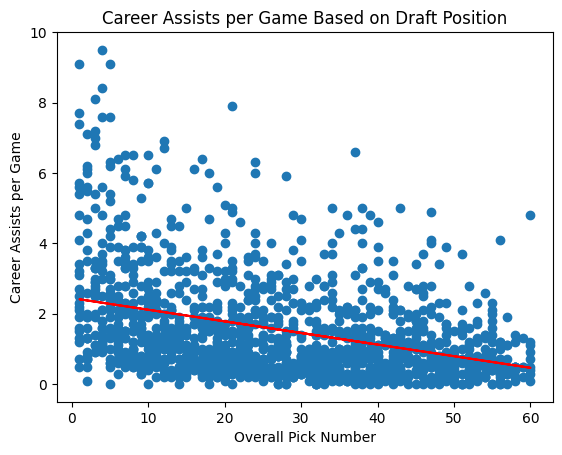

In [10]:
# part 3: career assists per game
draft_position = df[['overall_pick']].values.reshape(-1,1).astype(int)
ast = df[['AST']].values.reshape(-1,1).astype(float)
X_train, X_test, y_train, y_test = train_test_split(draft_position, ast, test_size=0.2, random_state = 123)

# create model and fit to data
model = LinearRegression()
model.fit(draft_position, ast)
coeff = model.score(draft_position, ast)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
y_pred = X_test * slope + intercept
y_pred = y_pred.round(decimals = 1)

# regression coefficient
print('The regression coefficient is', coeff)
print()

# plotting
plt.scatter(draft_position, ast)
plt.plot(draft_position, (draft_position * slope + intercept), 'r')
plt.title('Career Assists per Game Based on Draft Position')
plt.xlabel('Overall Pick Number')
plt.ylabel('Career Assists per Game')
plt.ylim([-0.5,10])
plt.show()

The regression coefficient is 0.3041412293006325



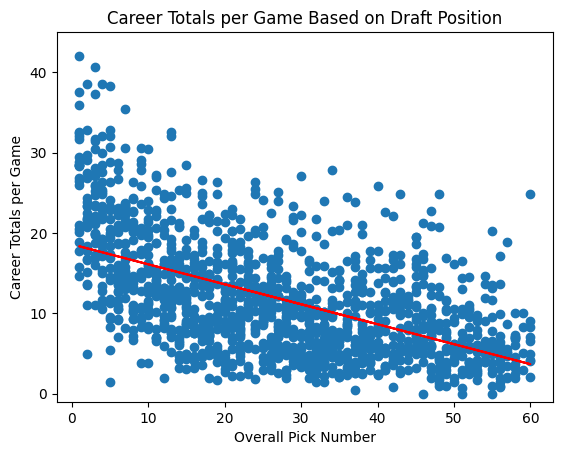

In [11]:
# part 4: career stats per game
draft_position = df[['overall_pick']].values.reshape(-1,1).astype(int)
df['total'] = df['PTS'] + df['TRB'] + df['AST']
total = df[['total']].values.reshape(-1,1).astype(float)
X_train, X_test, y_train, y_test = train_test_split(draft_position, total, test_size=0.2, random_state = 123)

# create model and fit to data
model = LinearRegression()
model.fit(draft_position, total)
coeff = model.score(draft_position, total)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
y_pred = X_test * slope + intercept
y_pred = y_pred.round(decimals = 1)

# regression coefficient
print('The regression coefficient is', coeff)
print()

# plotting
plt.scatter(draft_position, total)
plt.plot(draft_position, (draft_position * slope + intercept), 'r')
plt.title('Career Totals per Game Based on Draft Position')
plt.xlabel('Overall Pick Number')
plt.ylabel('Career Totals per Game')
plt.ylim([-1,45])
plt.show()

In each of these graphs, the red line is the regression line. While there is a slight correlation, we can conclude that it is very weak. The correlation coefficient between overall pick number and the four categories examined (career averages in points, rebounds, assists, and the total sum of these three) are all small, with the largest only being 0.3 (for the total sum of all three). This proves our assumption that there is a relationship, but a weak relationship, between draft position and career stats.

In conclusion, using a draft player's draft position to estimate the player's career stats is a weak model. 


### Question 2: Projections Based on Draft Position Groups

While using the exact draft position of players is a weak and mostly inaccurate model, can we group draftees and model the career statistics for each group, and will there be a strong correlation?

To begin, we first look players drafted just in the first round, and then narrow this down to the lottery picks within the first round. We use logistic regressions because these models are decent classifiers, are great for predicitng likelihoods, and are easy to train. A major focus of sports is to be able to predict trajectories based on past data, which is why we have different models.

First Logistic Regression (Career Length vs Offensive Career Stats):

This first model aims to fit a logistic regression to classify and extract the likelihood of having a lengthy NBA career depending on your career statistics. The reason why a logistic model was shown was because it can determine the likelihood of a lengthy career. Ideally, a model like this would be used as a projection for an early NBA player's career length based on their statistics of their first years. We defined a lengthy career as a career that lasts more than 5 seasons, since this is around the NBA average listed online. We chose 6 years as the threshold for classification of a short/lengthy career, and then trained the model using our data to check whether a career was lengthy or not. Our results show good recall and precision scores, and the accuracy score is decent to say that the model performs alright. Also, our ROC curve shows that our model is better than randomly classifying values.

7.83678756476684
Predicting the length of the NBA career (6 or more seasons, or less than 6 seasons) for first round draft picks based on the sum of career averages in points, rebounds, and assists: Accuracy = 0.8

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        66
           1       0.80      0.88      0.83        89

    accuracy                           0.80       155
   macro avg       0.80      0.79      0.79       155
weighted avg       0.80      0.80      0.80       155



C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\4273277796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1['3 Sum'] = round1["PTS"] + round1['AST'] + round1['TRB']


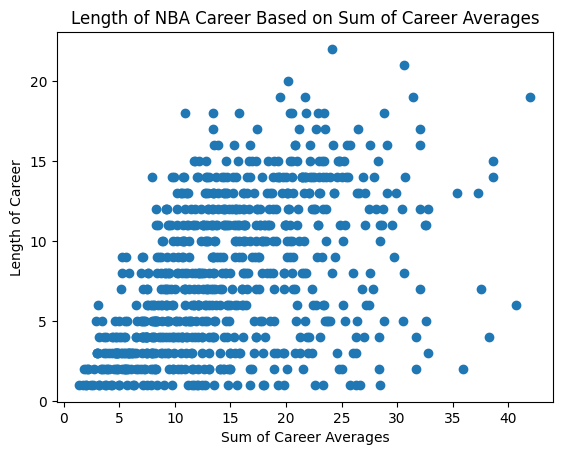

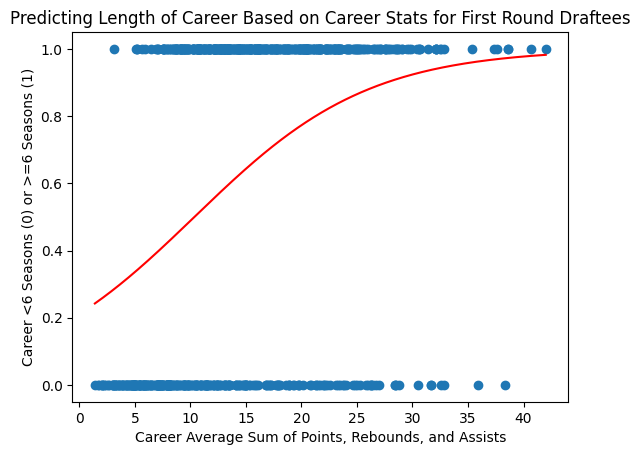

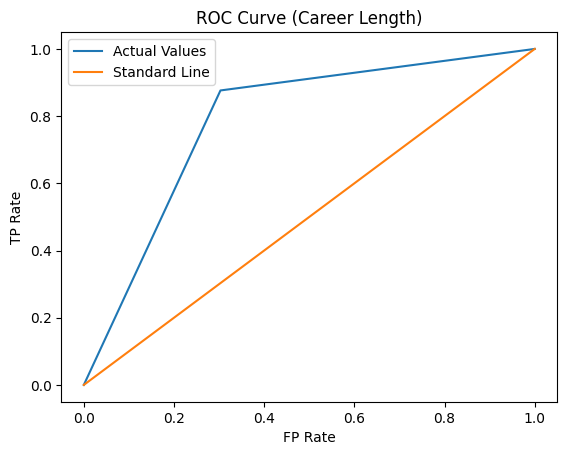

In [12]:
# Part 1: Predicting the Length of the NBA career for first round draftees
#         using the sum of career points, assists, and rebounds


# Create dataframe with only first round picks
round1 = df[df['round_number'] == 1] #just draft picks from the first round
round1['3 Sum'] = round1["PTS"] + round1['AST'] + round1['TRB']
print(round1['Years'].mean())

# Create classes depending on career length
round1_log = round1.copy()
years = round1['Years']
round1_log.loc[round1_log['Years'] < 6, 'Years'] = 0
round1_log.loc[round1_log['Years'] >= 6, 'Years'] = 1

# Create logistic model, train it with training data, and test the model
model = LogisticRegression()
xlog = round1_log['3 Sum'].values.reshape(-1, 1).astype(float)
ylog = round1_log['Years'].values.reshape(-1, 1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(xlog, ylog, test_size=0.2, random_state=123)
model.fit(X_train, np.ravel(y_train.astype(int)))
y_pred = model.predict(X_test)

# Print outs: results of logistic regression
string = 'Predicting the length of the NBA career (6 or more seasons, or less than 6 seasons) for first '
string += 'round draft picks based on the sum of career averages in points, rebounds, and assists: Accuracy = '
string += str(accuracy_score(y_test, y_pred))
print(string)
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))

# plotting
plt.figure()
plt.scatter(round1['3 Sum'], years)
plt.xlabel('Sum of Career Averages')
plt.ylabel('Length of Career')
plt.title('Length of NBA Career Based on Sum of Career Averages')

plt.figure()
plt.scatter(xlog, ylog)
plt.xlabel('Career Average Sum of Points, Rebounds, and Assists')
plt.ylabel('Career <6 Seasons (0) or >=6 Seasons (1)')
plt.title('Predicting Length of Career Based on Career Stats for First Round Draftees')
xDel2 = np.linspace(xlog.min(), xlog.max(),10000)
yDelProb2 = model.predict_proba(xDel2.reshape(-1,1))[:,1]
plt.plot(xDel2, yDelProb2, color = 'Red')


fpr2, tpr2, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr2, tpr2)
xline2 = np.linspace(0,1,10000)
yline2 = xline2
plt.plot(xline2, yline2)
plt.title('ROC Curve (Career Length)')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend(['Actual Values','Standard Line'])

Second Logistic Regression (All Star Selection vs. Offensive Career Stats):

In this regression, we focused on trying to see if a first round draft pick will be an All Star or not based on their career averages. The way we do this is by using a logistic regression to classify those players with certain offensive career statistics who've made the All Star game and try to make a prediction with the model. The interest in this is becasue it can help make an early projection/likelihood of a young player of making the All Star game sometime in the future of their career. Our results show that this model accurately predicted the results (95% accuracy), and it maintained decent results for precision and recall for both classes in the test data. The ROC curve further supports the validity of this model, as the area is greater than the standard 50% line.


Predicting if a first round draft pick will be an All Star based on the sum of career averages in points, rebounds, and assists: Accuracy = 0.9483870967741935

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       132
           1       0.89      0.74      0.81        23

    accuracy                           0.95       155
   macro avg       0.93      0.86      0.89       155
weighted avg       0.95      0.95      0.95       155



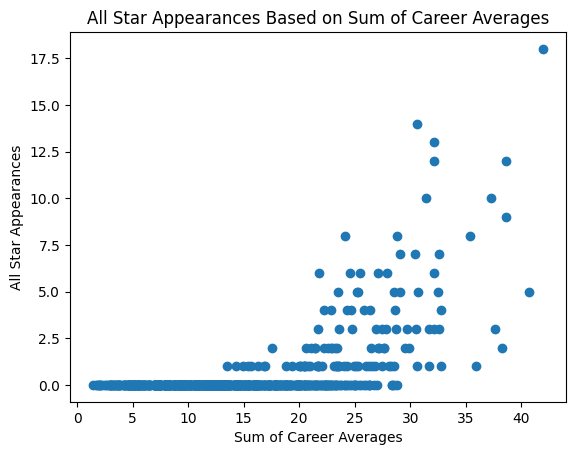

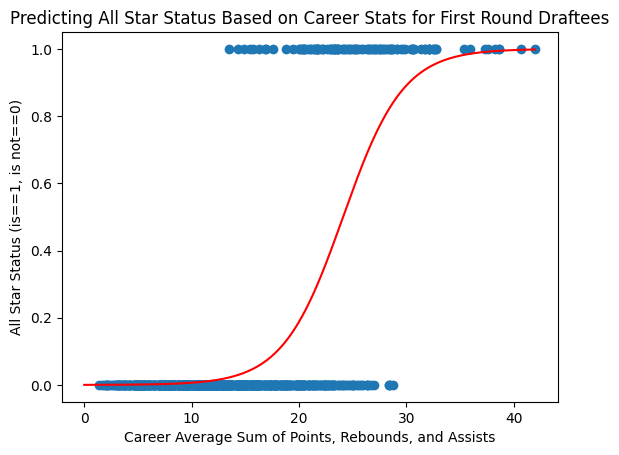

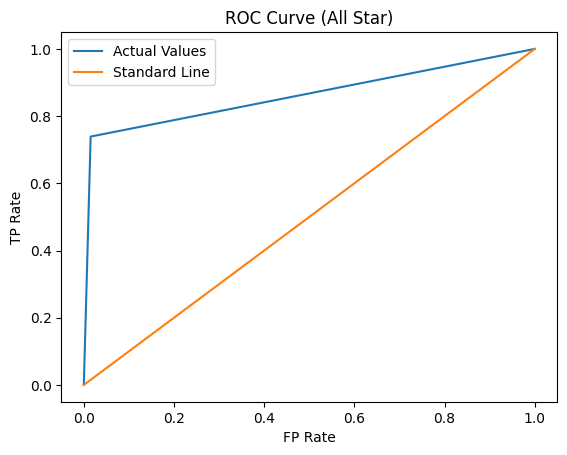

In [13]:
# Part 2: If a first round draft pick will be an eventual all star or not
#         using the sum of career averages in points, rebounds, and assists

# Classify players who made the all star game and add that to the dataframe
round1_log = round1.copy()
all_star = round1['All Star']
round1_log.loc[round1_log['All Star'] < 1, 'All Star'] = 0
round1_log.loc[round1_log['All Star'] >= 1, 'All Star'] = 1

# Make logistic regression model and test it 
model = LogisticRegression()
xlog = round1_log['3 Sum'].values.reshape(-1, 1)
ylog = round1_log['All Star'].values.reshape(-1, 1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(xlog, ylog, test_size=0.2, random_state=10)
model.fit(X_train, np.ravel(y_train.astype(int)))
y_pred = model.predict(X_test)

# Print outs: results of logistic regression
string = 'Predicting if a first round draft pick will be an All Star based on the sum of'
string += ' career averages in points, rebounds, and assists: Accuracy = '
string += str(accuracy_score(y_test, y_pred))
print(string)
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))

# plotting:
plt.figure()
plt.scatter(round1['3 Sum'], all_star)
plt.xlabel('Sum of Career Averages')
plt.ylabel('All Star Appearances')
plt.title('All Star Appearances Based on Sum of Career Averages')

plt.figure()
plt.scatter(xlog, ylog)
plt.xlabel('Career Average Sum of Points, Rebounds, and Assists')
plt.ylabel('All Star Status (is==1, is not==0)')
plt.title('Predicting All Star Status Based on Career Stats for First Round Draftees')
xDel2 = np.linspace(0, xlog.max(),10000)
yDelProb2 = model.predict_proba(xDel2.reshape(-1,1))[:,1]
plt.plot(xDel2, yDelProb2, color = 'Red')

fpr2, tpr2, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr2, tpr2)
xline2 = np.linspace(0,1,10000)
yline2 = xline2
plt.plot(xline2, yline2)
plt.title('ROC Curve (All Star)')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend(['Actual Values','Standard Line'])

Third Logistic Regression (Winning Individual Award vs draft pick):

Lastly, we want to see if we can predict a player winning an individual award based on their draft pick. We use a logistic regression to predict this, and initially, our data seemed very spontaneous, so we trained our model using the median result for winning an award for each of the round picks. The reason why we used the mean was mainly because choosing random training data heavily skewed our results to certain draft picks, and the model always failed this way. The mean we used had a threshold of 0.4 to separate the data, since that's what the scatter plot seemed to lean towards for the lottery picks and also is a fair measure to determine whether a player won some sort of award or not. The resulting logistic regression was then tested with random samples from the data, and it gave positive results, but seemed weak. We would need more concrete means to see a better correlation between being a lottery pick and having a high probability of winning an award, or we could have implemented some sort of bootstrapping method with our samples, but even that didn't seem to work out too well (worked it out on a seperate file). Our ROC Curve shows that the results also are better than a random prediction, which supports the results of the model, but this might even be skewed by the ones classified as having won no award. 

0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89        23
         1.0       0.67      0.57      0.62         7

    accuracy                           0.83        30
   macro avg       0.77      0.74      0.75        30
weighted avg       0.83      0.83      0.83        30



C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\3062507595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1['Award'] =  round1['DPOY'] + round1['MVP'] + round1['Finals MVP'] + round1['BLK Champ'] + round1['STL Champ'] + round1['TRB Champ'] + round1['AST Champ'] + round1['Scoring Champ'] + round1['Sixth Man'] + round1['ROY'] + round1['CF MVP'] + round1['Sixth Man']
C:\Users\jchav\AppData\Local\Temp\ipykernel_5488\3062507595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1['Award Ind'] = 

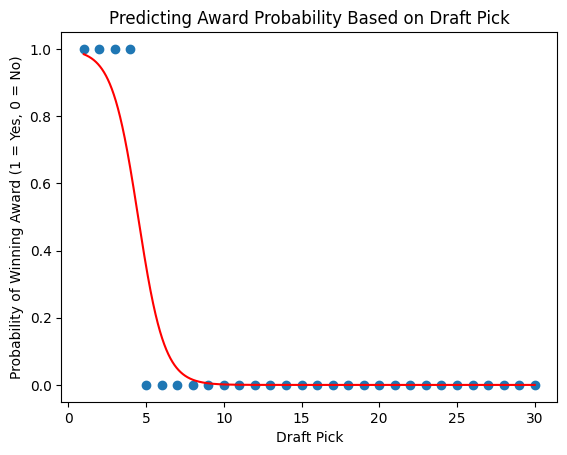

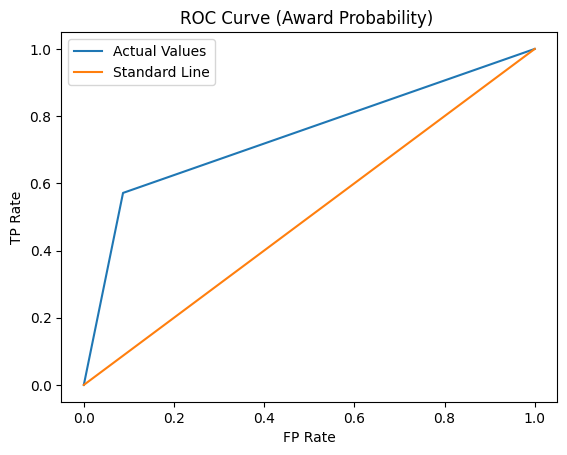

In [16]:


# Get all the Individual awards possible for all first round picks
round1['Award'] =  round1['DPOY'] + round1['MVP'] + round1['Finals MVP'] + round1['BLK Champ'] + round1['STL Champ'] + round1['TRB Champ'] + round1['AST Champ'] + round1['Scoring Champ'] + round1['Sixth Man'] + round1['ROY'] + round1['CF MVP'] + round1['Sixth Man']
round1['Award Ind'] = np.zeros(len(round1))
round1.loc[round1['Award'] > 0, 'Award Ind'] = 1
round1.loc[round1['Award'] <= 0, 'Award Ind'] = 0

m = round1['round_pick'].unique()
m.sort()

#print(m)
#plt.figure()
# for i in m:
#     plt.scatter(round1[round1['round_pick'] == i]['round_pick'], round1[round1['round_pick'] == i]['Award'])
# plt.title('Round Pick and PPG of all data set')
# plt.xlabel('Round Pick')
# plt.ylabel('PPG')

# Obtain the average
avg = []
for i in m:
    avg.append(round1[round1['round_pick'] == i]['Award'].mean())
#print(avg)
m = np.array(avg)
y_val = m>0.4
y_val = y_val.astype(int)

# Generate data for training/testing and fit the model (testing was done by getting 30 random samples)
round_val = np.linspace(1, 30, 30).reshape(-1, 1)
y_val = y_val.reshape(-1, 1).astype(int)
model3 = LogisticRegression()
model3 = model3.fit(round_val, y_val)
y_test = round1.sample(n=30, random_state = 10, replace = True)
y_pred = model3.predict(y_test['round_pick'].values.reshape(-1, 1))
print(accuracy_score(y_test['Award Ind'], y_pred))
print(classification_report(y_test['Award Ind'].values.reshape(-1, 1), y_pred))

plt.figure()
plt.scatter(round_val, y_val)
xDel2 = np.linspace(round_val.min(), round_val.max(),10000)
yDelProb2 = model3.predict_proba(xDel2.reshape(-1,1))[:,1]
plt.plot(xDel2, yDelProb2, color = 'Red')
plt.title('Predicting Award Probability Based on Draft Pick')
plt.xlabel('Draft Pick')
plt.ylabel('Probability of Winning Award (1 = Yes, 0 = No)')

fpr2, tpr2, _ = roc_curve(y_test['Award Ind'].values.reshape(-1, 1), y_pred)
plt.figure()
plt.plot(fpr2, tpr2)
xline2 = np.linspace(0,1,10000)
yline2 = xline2
plt.plot(xline2, yline2)
plt.title('ROC Curve (Award Probability) ')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend(['Actual Values','Standard Line'])

Hypothesis Test (Lottery Picks vs Non-lottery Picks Mean Offensive Stats Comparison):

We conducted a hypothesis test for lottery picks (top 4 picks in the NBA Draft) versus the rest of the picks in the first round. For this 2 population t-test, we need to be sure that both samples have normally distributed data and n >= 5 samples, which we meet. We plotted the PDF of both of our categories for the summation of the three major offense categories (PTS, TRBS, and AST), which resulted in a normally distribtued curve, meaning we could proceed with our hypothesis testing. We also made the assumption that the variances are not equal, since our density plots seem to have different widths. We wanted to test to see if our lottery picks would have a larger mean than our non-lottery, thus we tried to prove that the means were not equal in our null and wanted a larger lottery pick mean in our alternative. Our results show that even with a small alpha value of 0.01, we can confidently reject our null hypothesis (which is that the mean of the lottery picks is the same as the mean of the non-lottery picks) since our p-values are all significantly smaller than the alpha value of 0.01.

Hypothesis test for points:   Ttest_indResult(statistic=12.396513232854074, pvalue=2.9372415706054404e-32)
Hypothesis test for assists:  Ttest_indResult(statistic=7.580464118651341, pvalue=5.862561106831491e-14)
Hypothesis test for rebounds: Ttest_indResult(statistic=9.73811925169655, pvalue=1.9208332465635796e-21)
Hypothesis test for sum:      Ttest_indResult(statistic=13.009887175584891, pvalue=4.1668752487279395e-35)

Lottery picks career points average: 11.122015915119363
Number of lottery picks in our data set: 377
Standard deviation: 5.2577013594205235

Non-lottery picks career points average: 7.025316455696203
Number of non-lottery picks in our data set: 395
Standard deviation: 3.7650162414096937


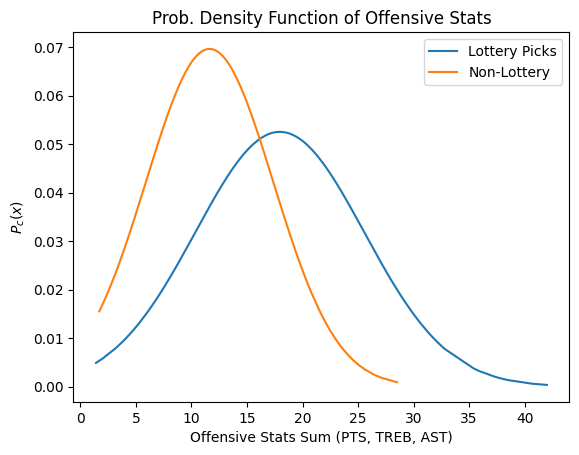

In [18]:
# Part 3: Hypothesis testing For lottery picks in the first round
#         using the sum of career averages in points, rebounds, and assists

from scipy.stats import ttest_ind
from statistics import stdev
from scipy import stats

lottery_picks = round1[(round1['round_pick'] >= 1) & (round1['round_pick'] <= 14)]
non_lottery = round1[(round1['round_pick'] > 14)]

# Plotting PDF
pdf_x = lottery_picks['3 Sum'].sort_values()
pdf_y = stats.norm.pdf(pdf_x, pdf_x.mean(), pdf_x.std())
pdf_x2 = non_lottery['3 Sum'].sort_values()
pdf_y2 = stats.norm.pdf(pdf_x2, pdf_x2.mean(), pdf_x2.std())
plt.figure()
plt.plot(pdf_x,pdf_y)
plt.plot(pdf_x2, pdf_y2)
plt.legend(['Lottery Picks', 'Non-Lottery'])
plt.xlabel('Offensive Stats Sum (PTS, TREB, AST)')
plt.ylabel("$P_{c}(x)$")
plt.title('Prob. Density Function of Offensive Stats')

# hypothesis tests, and printing:
pts_ht = ttest_ind(lottery_picks['PTS'], non_lottery['PTS'], equal_var = False, alternative = 'greater')
ast_ht = ttest_ind(lottery_picks['AST'], non_lottery['AST'], equal_var = False,  alternative = 'greater')
trb_ht = ttest_ind(lottery_picks['TRB'], non_lottery['TRB'], equal_var = False,  alternative = 'greater')
sum_ht = ttest_ind(lottery_picks['3 Sum'], non_lottery['3 Sum'], equal_var = False, alternative = 'greater')
print('Hypothesis test for points:  ', pts_ht)
print('Hypothesis test for assists: ', ast_ht)
print('Hypothesis test for rebounds:', trb_ht)
print('Hypothesis test for sum:     ', sum_ht)
print()

# print outs: various hypothesis testing values
s1 = 'Lottery picks career points average:'
s2 = 'Number of lottery picks in our data set:'
s3 = 'Non-lottery picks career points average:'
s4 = 'Number of non-lottery picks in our data set:'
s5 = 'Standard deviation:'
print(s1 ,lottery_picks['PTS'].mean())
print(s2, len(lottery_picks['PTS']))
print(s5, stdev(lottery_picks['PTS']))
print()
print(s3, non_lottery['PTS'].mean())
print(s4, len(non_lottery['PTS']))
print(s5, stdev(non_lottery['PTS']))